In [ ]:
!pip install tensorflow-addons

# Import library
import cv2
import pylab
import argparse
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
from tqdm import tqdm
from matplotlib import pyplot as plt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 12.7 MB/s 


In [ ]:
# Download gambar
!wget --no-check-certificate \
    https://raw.githubusercontent.com/azmirizkifar20/Image-Morphing/main/image_5.jpg \
    -O image_1.jpg

!wget --no-check-certificate \
    https://raw.githubusercontent.com/azmirizkifar20/Image-Morphing/main/image_6.jpg \
    -O image_2.jpg

--2022-11-16 11:04:58--  https://raw.githubusercontent.com/azmirizkifar20/Image-Morphing/main/image_5.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23039 (22K) [image/jpeg]
Saving to: ‘image_1.jpg’

image_1.jpg         100%[===================>]  22.50K  --.-KB/s    in 0s      

2022-11-16 11:04:58 (64.9 MB/s) - ‘image_1.jpg’ saved [23039/23039]

--2022-11-16 11:04:58--  https://raw.githubusercontent.com/azmirizkifar20/Image-Morphing/main/image_6.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29637 (29K) [image/jpeg]
Sa

In [ ]:
# kontrol ukuran gambar
pylab.rcParams['figure.figsize'] = (10.0, 8.0)

In [ ]:
input_image = cv2.imread('image_1.jpg')

# ukuran gambar
input_image.size

750000

In [ ]:
# resolusi gambar
print(input_image.shape)

# document type
print(input_image.dtype)

(500, 500, 3)
uint8


Tampilkan gambar input.

Perlu dilakukan merging image karena secara default OpenCV tidak menampilkan gambar dalam format RGB, melainkan format BGR.

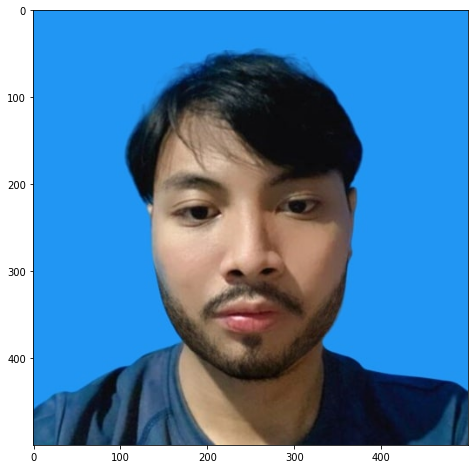

In [ ]:
# split channels
b,g,r = cv2.split(input_image)
merged = cv2.merge([r,g,b])

# merge takes an array of single channel matrices
plt.imshow(merged)

In [ ]:
# Inisiasi variabel
ORIG_WIDTH = 0
ORIG_HEIGHT = 0
im_sz = 1024
mp_sz = 96

Proses pembangunan fungsi dan model untuk morphing image dengan bantuan tensorflow.

Referensi:
https://github.com/volotat/DiffMorph

In [ ]:
@tf.function
def warp(origins, targets, preds_org, preds_trg):
    if add_first:
        res_targets = tfa.image.dense_image_warp((origins + preds_org[:,:,:,3:6] * 2 * add_scale) * tf.maximum(0.1, 1 + preds_org[:,:,:,0:3] * mult_scale) , preds_org[:,:,:,6:8] * im_sz * warp_scale )
        res_origins = tfa.image.dense_image_warp((targets + preds_trg[:,:,:,3:6] * 2 * add_scale) * tf.maximum(0.1, 1 + preds_trg[:,:,:,0:3] * mult_scale) , preds_trg[:,:,:,6:8] * im_sz * warp_scale )
    else:
        res_targets = tfa.image.dense_image_warp(origins * tf.maximum(0.1, 1 + preds_org[:,:,:,0:3] * mult_scale) + preds_org[:,:,:,3:6] * 2 * add_scale, preds_org[:,:,:,6:8] * im_sz * warp_scale )
        res_origins = tfa.image.dense_image_warp(targets * tf.maximum(0.1, 1 + preds_trg[:,:,:,0:3] * mult_scale) + preds_trg[:,:,:,3:6] * 2 * add_scale, preds_trg[:,:,:,6:8] * im_sz * warp_scale )

    return res_targets, res_origins

def create_grid(scale):
    grid = np.mgrid[0:scale,0:scale] / (scale - 1) * 2 -1
    grid = np.swapaxes(grid, 0, 2)
    grid = np.expand_dims(grid, axis=0)
    return grid

In [ ]:
def produce_warp_maps(origins, targets):
    class MyModel(tf.keras.Model):
        def __init__(self):
            super(MyModel, self).__init__()
            self.conv1 = tf.keras.layers.Conv2D(64, (5, 5))
            self.act1 = tf.keras.layers.LeakyReLU(alpha=0.2)
            self.conv2 = tf.keras.layers.Conv2D(64, (5, 5))
            self.act2 = tf.keras.layers.LeakyReLU(alpha=0.2)
            self.convo = tf.keras.layers.Conv2D((3 + 3 + 2) * 2, (5, 5))

        def call(self, maps):
            x = tf.image.resize(maps, [mp_sz, mp_sz])
            x = self.conv1(x)
            x = self.act1(x)
            x = self.conv2(x)
            x = self.act2(x)
            x = self.convo(x)
            return x


    model = MyModel()

    loss_object = tf.keras.losses.MeanSquaredError()
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002)

    train_loss = tf.keras.metrics.Mean(name='train_loss')

    @tf.function
    def train_step(maps, origins, targets):
      with tf.GradientTape() as tape:
        preds = model(maps)
        preds = tf.image.resize(preds, [im_sz, im_sz])

        res_targets_, res_origins_ = warp(origins, targets, preds[...,:8], preds[...,8:])
        res_map = tfa.image.dense_image_warp(maps, preds[:,:,:,6:8] * im_sz * warp_scale ) # warp maps consistency checker
        res_map = tfa.image.dense_image_warp(res_map, preds[:,:,:,14:16] * im_sz * warp_scale )

        loss = loss_object(maps, res_map) * 1 + loss_object(res_targets_, targets) * 0.3 + loss_object(res_origins_, origins) * 0.3

      gradients = tape.gradient(loss, model.trainable_variables)
      optimizer.apply_gradients(zip(gradients, model.trainable_variables))

      train_loss(loss)

    maps = create_grid(im_sz)
    maps = np.concatenate((maps, origins * 0.1, targets * 0.1), axis=-1).astype(np.float32)

    epoch = 0
    template = 'Epoch {}, Loss: {}'

    t = tqdm(range(TRAIN_EPOCHS), desc=template.format(epoch, train_loss.result()))

    for i in t:
        epoch = i + 1

        t.set_description(template.format(epoch, train_loss.result()))
        t.refresh()

        train_step(maps, origins, targets)

        if (epoch < 100 and epoch % 10 == 0) or\
           (epoch < 1000 and epoch % 100 == 0) or\
           (epoch % 1000 == 0):
            preds = model(maps, training=False)[:1]
            preds = tf.image.resize(preds, [im_sz, im_sz])

            res_targets, res_origins = warp(origins, targets, preds[...,:8], preds[...,8:])

            res_targets = tf.clip_by_value(res_targets, -1, 1)[0]
            res_img = ((res_targets.numpy() + 1) * 127.5).astype(np.uint8)

            res_img = cv2.resize(res_img, (ORIG_WIDTH, ORIG_HEIGHT), interpolation = cv2.INTER_AREA)

            cv2.imwrite("train/a_to_b_%d.jpg" % epoch, cv2.cvtColor(res_img, cv2.COLOR_RGB2BGR))

            res_origins = tf.clip_by_value(res_origins, -1, 1)[0]
            res_img = ((res_origins.numpy() + 1) * 127.5).astype(np.uint8)

            res_img = cv2.resize(res_img, (ORIG_WIDTH, ORIG_HEIGHT), interpolation = cv2.INTER_AREA)

            cv2.imwrite("train/b_to_a_%d.jpg" % epoch, cv2.cvtColor(res_img, cv2.COLOR_RGB2BGR))

            np.save('preds.npy', preds.numpy())

In [ ]:
def use_warp_maps(origins, targets, fps, steps):
    STEPS = steps
    preds = np.load('preds.npy')

    #save maps as images
    res_img = np.zeros((im_sz * 2, im_sz * 3, 3))

    res_img[im_sz*0:im_sz*1, im_sz*0:im_sz*1] = preds[0,:,:,0:3] # a_to_b add map
    res_img[im_sz*0:im_sz*1, im_sz*1:im_sz*2] = preds[0,:,:,3:6] # a_to_b mult map
    res_img[im_sz*0:im_sz*1, im_sz*2:im_sz*3, :2] = preds[0,:,:,6:8] # a_to_b warp map

    res_img[im_sz*1:im_sz*2, im_sz*0:im_sz*1] = preds[0,:,:,8:11] # b_to_a add map
    res_img[im_sz*1:im_sz*2, im_sz*1:im_sz*2] = preds[0,:,:,11:14] # b_to_a mult map
    res_img[im_sz*1:im_sz*2, im_sz*2:im_sz*3, :2] = preds[0,:,:,14:16] # b_to_a warp map

    res_img = np.clip(res_img, -1, 1)
    res_img = ((res_img + 1) * 127.5).astype(np.uint8)
    cv2.imwrite("maps.jpg", cv2.cvtColor(res_img, cv2.COLOR_RGB2BGR))


    #apply maps and save results

    org_strength = tf.reshape(tf.range(STEPS, dtype=tf.float32), [STEPS, 1, 1, 1]) / (STEPS - 1)
    trg_strength = tf.reverse(org_strength, axis = [0])

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    video = cv2.VideoWriter('output.mp4', fourcc, fps, (ORIG_WIDTH, ORIG_HEIGHT))

    res_img = np.zeros((im_sz * 3, im_sz * (STEPS // 10), 3), dtype = np.uint8)

    for i in tqdm(range(STEPS)):
        preds_org = preds * org_strength[i]
        preds_trg = preds * trg_strength[i]

        res_targets, res_origins = warp(origins, targets, preds_org[...,:8], preds_trg[...,8:])
        res_targets = tf.clip_by_value(res_targets, -1, 1)
        res_origins = tf.clip_by_value(res_origins, -1, 1)

        results = res_targets * trg_strength[i] + res_origins * org_strength[i]
        res_numpy = results.numpy()

        img = ((res_numpy[0] + 1) * 127.5).astype(np.uint8)
        output_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        output_img = cv2.resize(output_img, (ORIG_WIDTH, ORIG_HEIGHT), interpolation = cv2.INTER_AREA)

        video.write(output_img)

        if (i+1) % 10 == 0:
            res_img[im_sz*0:im_sz*1, i // 10 * im_sz : (i // 10 + 1) * im_sz] = img
            res_img[im_sz*1:im_sz*2, i // 10 * im_sz : (i // 10 + 1) * im_sz] = ((res_targets.numpy()[0] + 1) * 127.5).astype(np.uint8)
            res_img[im_sz*2:im_sz*3, i // 10 * im_sz : (i // 10 + 1) * im_sz] = ((res_origins.numpy()[0] + 1) * 127.5).astype(np.uint8)

    cv2.imwrite("output.jpg", cv2.cvtColor(res_img, cv2.COLOR_RGB2BGR))

    cv2.destroyAllWindows()
    video.release()
    print ('Output video berhasil disimpan!')

# Menjalankan proses morphing

In [ ]:
# Set variabel
TRAIN_EPOCHS = 100
add_scale = 0.4
mult_scale = 0.4
warp_scale = 0.05
add_first = False

In [ ]:
# Set gambar untuk before (source) dan after (destination)
image_source = cv2.imread('image_1.jpg', cv2.IMREAD_COLOR)
image_destination = cv2.imread('image_2.jpg', cv2.IMREAD_COLOR)

# cek kesamaan dimensi/resolusi gambar
if (image_source.shape[1] != image_destination.shape[1] or image_source.shape[0] != image_destination.shape[0]):
        print("Input Image is not the same dimensions as Destination Image.")
        exit()

In [ ]:
# Simpan ukuran lebar dan tinggi gambar source
ORIG_WIDTH = image_source.shape[1]
ORIG_HEIGHT = image_source.shape[0]

print('Lebar x Panjang -> {} x {}'.format(ORIG_WIDTH, ORIG_HEIGHT))

Lebar x Panjang -> 500 x 500


In [ ]:
image_source = cv2.cvtColor(image_source, cv2.COLOR_BGR2RGB)
image_source = cv2.resize(image_source, (im_sz, im_sz), interpolation = cv2.INTER_AREA)
image_source = image_source / 127.5 - 1

image_destination = cv2.cvtColor(image_destination, cv2.COLOR_BGR2RGB)
image_destination = cv2.resize(image_destination, (im_sz, im_sz), interpolation = cv2.INTER_AREA)
image_destination = image_destination / 127.5 - 1

In [ ]:
# Set origin (gambar source) dan target (gambar destination)
origins = image_source.reshape(1, im_sz, im_sz, 3).astype(np.float32) 
targets = image_destination.reshape(1, im_sz, im_sz, 3).astype(np.float32)

# Eksekusi program untuk proses morphing
produce_warp_maps(origins, targets)
use_warp_maps(origins, targets, fps=60, steps=100)

100%|██████████| 100/100 [00:22<00:00,  4.54it/s]


Output video berhasil disimpan!


Hasil proses morphing image

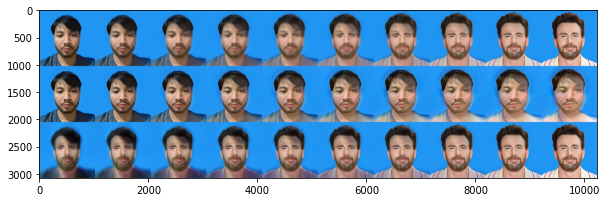

In [ ]:
output_image = cv2.imread('output.jpg')

# split channels
b,g,r = cv2.split(output_image)
merged = cv2.merge([r,g,b])

# merge takes an array of single channel matrices
plt.imshow(merged)

Konversi hasil morphing gambar dari video (mp4) ke gif untuk ditampilkan hasil morphingnya

In [ ]:
! apt-get install ffmpeg

Reading package lists... Done
Building dependency tree       
Reading state information... Done
ffmpeg is already the newest version (7:3.4.11-0ubuntu0.1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 5 not upgraded.


In [ ]:
! wget https://gif.ski/gifski-0.10.1.zip
! unzip gifski-0.10.1.zip

--2022-11-16 11:08:31--  https://gif.ski/gifski-0.10.1.zip
Resolving gif.ski (gif.ski)... 83.169.2.68, 2a01:488:66:1000:53a9:244:0:1
Connecting to gif.ski (gif.ski)|83.169.2.68|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1524127 (1.5M) [application/zip]
Saving to: ‘gifski-0.10.1.zip’

gifski-0.10.1.zip   100%[===================>]   1.45M  --.-KB/s    in 0.09s   

2022-11-16 11:08:31 (16.3 MB/s) - ‘gifski-0.10.1.zip’ saved [1524127/1524127]

Archive:  gifski-0.10.1.zip
  inflating: LICENSE                 
  inflating: README.md               
   creating: mac/
  inflating: mac/gifski              
   creating: win/
  inflating: win/gifski.exe          
   creating: linux/
  inflating: linux/gifski_0.10.1_amd64.deb  


In [ ]:
import os
import subprocess

In [ ]:
os.chdir('linux')
! dpkg -i gifski_0.10.1_amd64.deb

Selecting previously unselected package gifski.
(Reading database ... 123991 files and directories currently installed.)
Preparing to unpack gifski_0.10.1_amd64.deb ...
Unpacking gifski (0.10.1) ...
Setting up gifski (0.10.1) ...


In [ ]:
os.chdir('/content')
! git init
! git remote add -f origin https://github.com/fengredrum/tiny-gif-converter.git
! git config core.sparsecheckout true
! echo sample >> .git/info/sparse-checkout
! git pull origin master

Initialized empty Git repository in /content/.git/
Updating origin
remote: Enumerating objects: 158, done.
remote: Total 158 (delta 0), reused 0 (delta 0), pack-reused 158
Receiving objects: 100% (158/158), 42.81 MiB | 18.45 MiB/s, done.
Resolving deltas: 100% (83/83), done.
From https://github.com/fengredrum/tiny-gif-converter
 * [new branch]      master     -> origin/master
 * [new tag]         v0.1-alpha -> v0.1-alpha
From https://github.com/fengredrum/tiny-gif-converter
 * branch            master     -> FETCH_HEAD


In [ ]:
def gif_converter(
    load_path=None,
    save_path=None,
    start_time='00:00:00',
    duration='5.',
    fps='10',
    frame_width='320',
):
    # Setup path
    if load_path is None:
        load_path = 'output.mp4'
    if save_path is None:
        save_path = 'output/'
        os.makedirs(save_path, exist_ok=True)

    subprocess.call(['mkdir', 'tmp/'])

    # Extract frames
    subprocess.call([
                    'ffmpeg',
                    '-ss', start_time,  # start time
                    '-t', duration,  # duration
                    '-i', load_path,  # original file dir
                    '-vf', "fps=" + fps + ", scale=" + frame_width + ":-1",
                    '-pix_fmt', 'rgb24',  # pixel formats
                    # output file dir
                    '-y', 'tmp/frame%04d.png',
                    ])

    # Create GIF
    out_file_name = os.path.basename(load_path) + '_converted.gif'
    ex = subprocess.Popen("gifski --fps " + fps + " -o " +
                          os.path.join(save_path, out_file_name) +
                          " tmp/frame*.png", 
                          stdout=subprocess.PIPE,
                          universal_newlines=True,
                          shell=True)

    while ex.poll() == None:
        print(ex.stdout.readline())

    status = ex.wait()
    subprocess.call(['rm', '-rf', 'tmp/'])

In [ ]:
load_path = 'output.mp4'
gif_converter(load_path=load_path)



Frame 1 / 17  ###_.........................................................  2s 

Frame 4 / 17  ##############_..............................................  1s 

Frame 7 / 17  #########################_...................................  1s 

Frame 10 / 17  ###################################_........................  1s 

Frame 13 / 17  #############################################_..............  0s 

Frame 16 / 17  ########################################################_...  0s 

Frame 17 / 17  ##############################################################   

Frame 17 / 17  ##############################################################   

gifski created output/output.mp4_converted.gif                                  


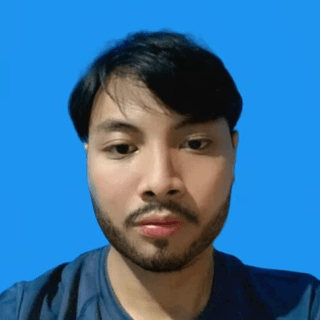

In [ ]:
from IPython.display import Image
out_path = os.path.join('output', os.path.basename(load_path) + '_converted.gif')
Image(open(out_path,'rb').read())